# Titanic - Machine Learning from Disaster <a id='top'></a>
Welcome! This notebook is going to build a model that predicts survival on the Titanic. The data used to build this model is collected from the [Kaggle's Titanic competition](https://www.kaggle.com/c/titanic/overview). 

The data is split into two groups: the training set (train.csv) and the test set (test.csv). The training set should be used to build the machine learning models. The test set should only be used for evaluating the model's performance.

Data dictionary:
| Variable | Definition | Key |
|----------|------------|-----|
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| age | Age in years | |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embark | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

Table of contents:
1. [Data Exploratory](#eda)
2. [Data Visualization](#data-visualization)
3. [Handle Missing Data](#handle-na)
4. [Preprocessing](#preprocessing)
5. [Building Models](#build-models)
6. [Load the test data](#load-test)

In [1]:
# Import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Model selection
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV

# Import the machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Import metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay


In [2]:
sns.set_style("darkgrid")
plt.style.use("seaborn-darkgrid")
pio.renderers.default = "notebook_connected"


## Data Exploratory <a id='eda'></a>
[Back to top](#top)

Import the train.csv

In [3]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.shape

(891, 12)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## Data Visualization <a id='data-visualization'></a>
[Back to top](#top)

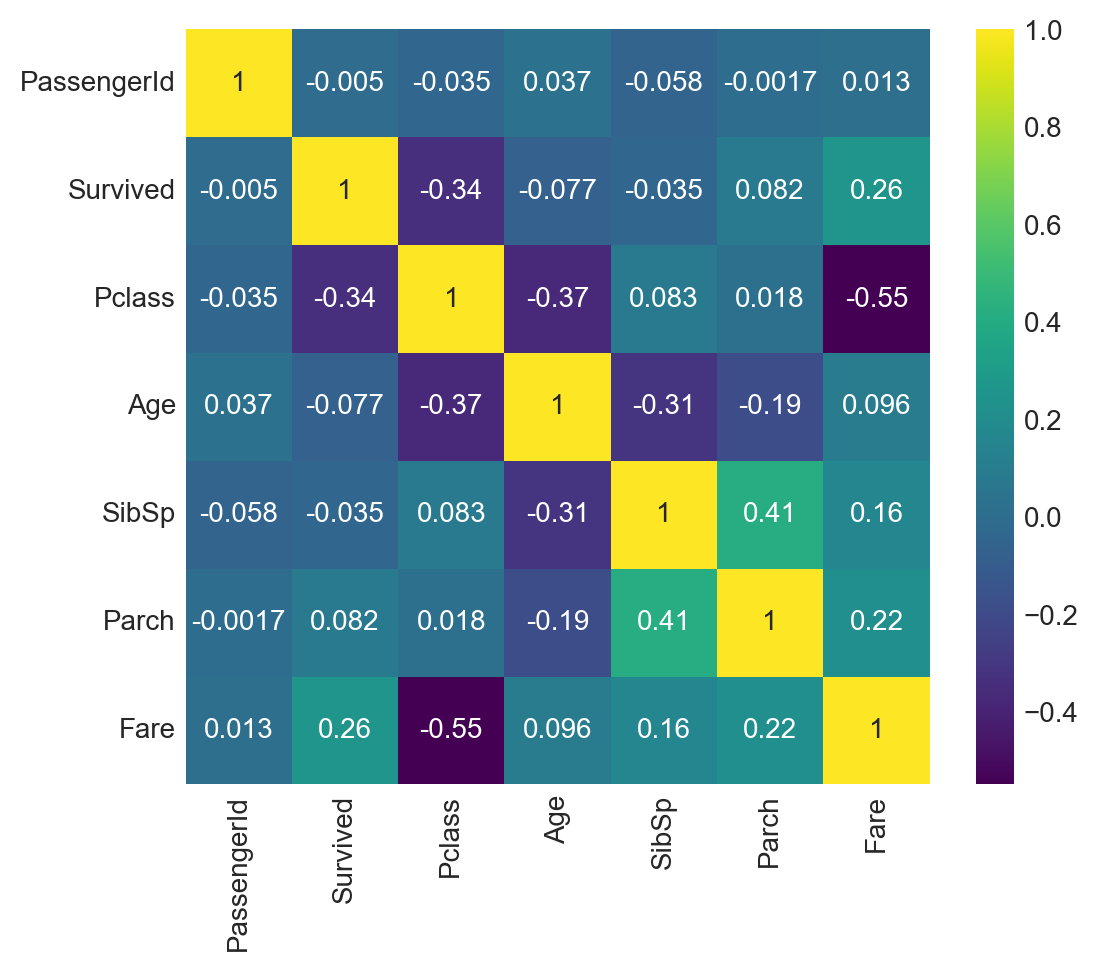

In [8]:
plt.figure(figsize=(6, 5), dpi=200)
sns.heatmap(train.corr(), annot=True, cmap='viridis')
plt.show()


In [9]:
fig = px.histogram(
    data_frame=train, x="Survived", title="How Many Died, How Many Survived?"
)
fig.update_layout(xaxis={"type": "category"})
fig.show()


Age distribution of male and female passengers aboard the Titanic:

In [10]:
fig = px.histogram(
    data_frame=train,
    x="Age",
    color="Sex",
    barmode="group",
    marginal="box",
    title="Age Distribution of Male and Female Passengers aboard the Titanic",
)
fig.show()


The majority of people aboard the Titanic were in their 20s and 30s.

Age distribution of passengers who did not survive:

In [11]:
fig = px.histogram(
    data_frame=train[train["Survived"] == 0],
    x="Age",
    color="Sex",
    barmode="group",
    marginal="box",
    title="Age distribution of Passengers whom did not survive the Disaster",
)
fig.show()


Passengers who died were mostly in their late 10s and early 40s, and were mainly male passengers.

In [12]:
fig = px.histogram(data_frame=train[train['Survived'] == 0], x='Sex', title='Number of Deceased Passengers')
fig.show()

It looks like a lot of male passengers died with the ship, nearly 6 times greater than that of female passengers.

Let's look at survival status for each class.

In [13]:
fig = px.box(
    data_frame=train,
    x="Pclass",
    y="Age",
    color="Survived",
    title="Age distribution per Class split by Survival status",
)
fig.show()


It looks like there is a same pattern for all three classes that older people did not survive.

In [14]:
fig = px.histogram(
    data_frame=train,
    x="Pclass",
    color="Survived",
    barmode="group",
    title="Number of Passengers per Class Split by Survival status",
)
fig.show()


And the third class accounted for more deaths than the other two classes.

Now I want to gain insight on the ports of embarkation. Which port has the most passengers?

In [15]:
fig = px.histogram(
    data_frame=train,
    x="Embarked",
    color="Survived",
    title="Number of Passengers at each Port Split by Survival status",
)
fig.show()


A lot of passengers boarded the Titanic at Southampton port.

Finally, probably not relevant, but I want to check if `SibSp`, `Parch` and `Fare` affect `Survived` or not.

In [16]:
unrelevant_features = train[["SibSp", "Parch", "Fare", "Survived"]].corr()
unrelevant_features['Survived']

SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Survived    1.000000
Name: Survived, dtype: float64

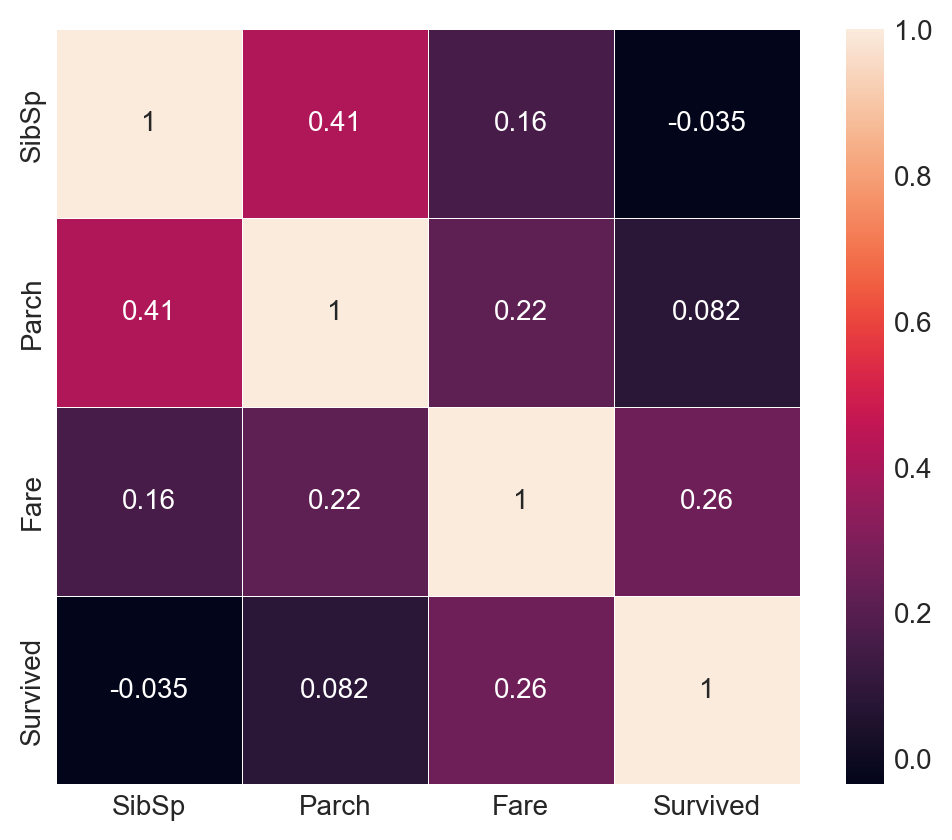

In [17]:
plt.figure(figsize=(6, 5), dpi=200)
sns.heatmap(unrelevant_features, annot=True, linewidths=0.3)
plt.show()


So it looks like the `Fare` actually have a positive relationship with `Survived`, not by much but worth noticing. Let's plot a box plot to visualize this clearer.

In [18]:
fig = px.box(
    data_frame=train,
    x="Survived",
    y="Fare",
    title="Does Fare affect Passengers' Survival Status?",
)
fig.show()


Looks like there is a segregation between rich and poor people. For example, the number of deceased passengers from third class is a lot greater than that of first class and second class. Or a lot of passengers who purchased higher fare ticket survived the event.

## Handle Missing Data <a id='handle-na'></a>
[Back to top](#top)

Let's take a look back our data to see which columns contain missing data.

In [19]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### The `Embarked` column
First, I want to drop the 2 missing values of the `Embarked` column since they only account for 0.2 percent of the entire data.

In [20]:
train = train.dropna(subset=['Embarked'])
train.isna().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

### The `Age` column
Next is the `Age` column. I want to look at the statistics for this column to strengthen my decision.

In [21]:
train['Age'].describe()

count    712.000000
mean      29.642093
std       14.492933
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [22]:
fig = px.histogram(data_frame=train, x="Age", marginal="box")
fig.show()


The mean and the median of `Age` column are pretty close together. I'm not done here. I want to see which class those passengers with missing age values are from.

In [23]:
train[train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [24]:
fig = px.histogram(
    data_frame=train[train["Age"].isna()],
    x="Pclass",
    title="Numbers of Passengers with Missing Age Values per Class",
)
fig.update_layout(xaxis={"categoryorder": "category ascending", "type": "category"})
fig.show()


Passengers with missing age values are mostly from third class. I want to fill in those missing values with the age median of the corresponding class. 

Meaning:
* Passengers with missing age values from first class will be filled with the age median of first class.
* Passengers with missing age values from second class will be filled with the age median of second class.
* Passengers with missing age values from third class will be filled with the age median of third class.

In [25]:
age_median_pclass = train.groupby('Pclass').median()['Age']
age_median_pclass

Pclass
1    37.0
2    29.0
3    24.0
Name: Age, dtype: float64

In [26]:
fig = px.box(data_frame=train, x="Pclass", y="Age", title="Age Distribution per Class before Filling Missing Values")
fig.show()


So:
* Missing age values of passengers from first class will be filled with 37.
* Missing age values of passengers from second class will be filled with 29.
* Missing age values of passengers from third class will be filled with 24.


In [27]:
def fill_age(pclass, age):
    if np.isnan(age):
        return age_median_pclass[pclass]
    else:
        return age


In [28]:
train["Age"] = train.apply(lambda table: fill_age(table["Pclass"], table["Age"]), axis=1)


In [29]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [30]:
fig = px.box(data_frame=train, x="Pclass", y="Age", title="Age Distribution per Class after Filling Missing Values")
fig.show()


### The `Cabin` column

In [31]:
train['Cabin'].sort_values()

583    A10
475    A14
556    A16
284    A19
599    A20
      ... 
884    NaN
885    NaN
886    NaN
888    NaN
890    NaN
Name: Cabin, Length: 889, dtype: object

In [32]:
fig = px.histogram(x=train["Cabin"].sort_values(), title="Cabin Value Counts")
fig.update_layout(xaxis_title="Unique Cabin Values")
fig.show()


I notice the naming convention is a letter followed by two or three digits. I also notice there are some strange cabin name entries such as `B57 B59 B63 B66`, `C23 C25 C27`, `D10 D12`, `C62 C64`, etc. Those cabins were probably occupied by members of the same family.

In [33]:
train[train["Cabin"] == "B57 B59 B63 B66"]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.375,B57 B59 B63 B66,C


The Ryerson family had 5 members including 3 siblings and 2 parents. They were staying in 4 cabins: B57, B59 B63 and B66. Only two sisters survived, the other members were missing.

In [34]:
train[train['Cabin'] == 'D10 D12']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.0,0,1,PC 17759,63.3583,D10 D12,C


Mr. William Bertram had one parent/child aboard the Titanic. He probalby stayed in one room and the other family member stayed in the other. Unfortunately, we don't know who the other family member is, probably that family member is the one that has `NaN` for Cabin number.

I want to create another column called "Cabin Class" which contains the first letter of each value in the "Cabin" column. This way, I can treat the "Cabin Class" column as the high-level class and the "Cabin" column as the detailed subclass of the "Cabin Class" column.

In [35]:
train["Cabin Class"] = train["Cabin"].map(lambda x: x[0], na_action="ignore")


In [36]:
test["Cabin Class"] = test["Cabin"].map(lambda x: x[0], na_action="ignore")


In [37]:
train[['Cabin', 'Cabin Class']]

,Cabin,Cabin Class
0,NaN,NaN
1,C85,C
2,NaN,NaN
3,C123,C
4,NaN,NaN
...,...,...
886,NaN,NaN
887,B42,B
888,NaN,NaN
889,C148,C


In [38]:
train['Cabin Class'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [39]:
test['Cabin Class'].unique()

array([nan, 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

For the `NaN` in the "Cabin Class", I want to assign **U** to them (U stands for unknown cabin class).

In [40]:
train['Cabin Class'] = train['Cabin Class'].fillna('U')
test['Cabin Class'] = test['Cabin Class'].fillna('U')

In [41]:
train['Cabin Class'].unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [42]:
test['Cabin Class'].unique()

array(['U', 'B', 'E', 'A', 'C', 'D', 'F', 'G'], dtype=object)

Now let's drop the "Cabin" column since it is not necessary anymore.

In [43]:
train = train.drop('Cabin', axis=1)
test = test.drop('Cabin', axis=1)

In [44]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Cabin Class    0
dtype: int64

In [45]:
test.isna().sum()

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
Cabin Class     0
dtype: int64

## Preprocessing <a id='preprocessing'></a>
[Back to top](#top)

In [46]:
train.sample(n=10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin Class
246,247,0,3,"Lindahl, Miss. Agda Thorilda Viktoria",female,25.0,0,0,347071,7.7750,S,U
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0000,S,B
594,595,0,2,"Chapman, Mr. John Henry",male,37.0,1,0,SC/AH 29037,26.0000,S,U
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,S,C
426,427,1,2,"Clarke, Mrs. Charles V (Ada Maria Winfield)",female,28.0,1,0,2003,26.0000,S,U
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,U
666,667,0,2,"Butler, Mr. Reginald Fenton",male,25.0,0,0,234686,13.0000,S,U
184,185,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,315153,22.0250,S,U
780,781,1,3,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,C,U
286,287,1,3,"de Mulder, Mr. Theodore",male,30.0,0,0,345774,9.5000,S,U


In [48]:
X_train = train.drop(
    ["PassengerId", "Survived", "Name", "Ticket", "SibSp", "Parch"], axis=1
)
y_train = train["Survived"]


X_test = test.drop(
    ["PassengerId", "Name", "Ticket", "SibSp", "Parch"], axis=1
)


In [49]:
X_train.columns


Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Cabin Class'], dtype='object')

In [50]:
categorical_columns = ["Sex", "Embarked", "Cabin Class"]

one_hot = OneHotEncoder(handle_unknown="ignore", drop='first')
column_transformer = ColumnTransformer(
    [("one_hot", one_hot, categorical_columns)], remainder="passthrough"
)

X_train = column_transformer.fit_transform(X_train)


In [51]:
column_transformer.get_feature_names_out()

array(['one_hot__Sex_male', 'one_hot__Embarked_Q', 'one_hot__Embarked_S',
       'one_hot__Cabin Class_B', 'one_hot__Cabin Class_C',
       'one_hot__Cabin Class_D', 'one_hot__Cabin Class_E',
       'one_hot__Cabin Class_F', 'one_hot__Cabin Class_G',
       'one_hot__Cabin Class_T', 'one_hot__Cabin Class_U',
       'remainder__Pclass', 'remainder__Age', 'remainder__Fare'],
      dtype=object)

In [52]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)


## Building Models <a id='build-models'></a>
[Back to top](#top)

* [Models' performance report with default hyperparameters](#default-report)
* [RandomizedSearchCV](#randomizedsearchcv)
* [GridSearchCV](#gridsearchcv)

We are going to train 3 models and compare the results of them. The three models are SVC, RandomForestClassifier and LogisticRegression.

First I'm going to build the models with the default hyperparameters and evaluate them using cross-validation.

In [53]:
svc = SVC()
cv_svc = cross_validate(
    svc, X_train, y_train, scoring=["accuracy", "recall", "precision"], cv=10, verbose=3
)


[CV] END  accuracy: (test=0.798) precision: (test=0.864) recall: (test=0.559) total time=   0.0s
[CV] END  accuracy: (test=0.775) precision: (test=0.750) recall: (test=0.618) total time=   0.0s
[CV] END  accuracy: (test=0.775) precision: (test=0.818) recall: (test=0.529) total time=   0.0s
[CV] END  accuracy: (test=0.831) precision: (test=0.788) recall: (test=0.765) total time=   0.0s
[CV] END  accuracy: (test=0.876) precision: (test=0.926) recall: (test=0.735) total time=   0.0s
[CV] END  accuracy: (test=0.798) precision: (test=0.808) recall: (test=0.618) total time=   0.0s
[CV] END  accuracy: (test=0.809) precision: (test=0.870) recall: (test=0.588) total time=   0.0s
[CV] END  accuracy: (test=0.764) precision: (test=0.760) recall: (test=0.559) total time=   0.0s
[CV] END  accuracy: (test=0.843) precision: (test=0.812) recall: (test=0.765) total time=   0.0s
[CV] END  accuracy: (test=0.818) precision: (test=0.875) recall: (test=0.618) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [54]:
rf_clf = RandomForestClassifier()
cv_rf_clf = cross_validate(
    rf_clf, X_train, y_train, scoring=["accuracy", "recall", "precision"], cv=10, verbose=3
)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] END  accuracy: (test=0.753) precision: (test=0.676) recall: (test=0.676) total time=   0.0s
[CV] END  accuracy: (test=0.831) precision: (test=0.771) recall: (test=0.794) total time=   0.0s
[CV] END  accuracy: (test=0.742) precision: (test=0.690) recall: (test=0.588) total time=   0.0s
[CV] END  accuracy: (test=0.831) precision: (test=0.757) recall: (test=0.824) total time=   0.0s
[CV] END  accuracy: (test=0.865) precision: (test=0.806) recall: (test=0.853) total time=   0.0s
[CV] END  accuracy: (test=0.798) precision: (test=0.735) recall: (test=0.735) total time=   0.0s
[CV] END  accuracy: (test=0.820) precision: (test=0.846) recall: (test=0.647) total time=   0.0s
[CV] END  accuracy: (test=0.798) precision: (test=0.750) recall: (test=0.706) total time=   0.0s
[CV] END  accuracy: (test=0.888) precision: (test=0.833) recall: (test=0.882) total time=   0.0s
[CV] END  accuracy: (test=0.818) precision: (test=0.781) recall: (test=0.735) total time=   0.0s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished


In [55]:
log_reg = LogisticRegression()
cv_log_reg = cross_validate(
    log_reg, X_train, y_train, scoring=["accuracy", "recall", "precision"], cv=10, verbose=3
)


[CV] END  accuracy: (test=0.753) precision: (test=0.688) recall: (test=0.647) total time=   0.0s
[CV] END  accuracy: (test=0.809) precision: (test=0.730) recall: (test=0.794) total time=   0.0s
[CV] END  accuracy: (test=0.775) precision: (test=0.733) recall: (test=0.647) total time=   0.0s
[CV] END  accuracy: (test=0.865) precision: (test=0.806) recall: (test=0.853) total time=   0.0s
[CV] END  accuracy: (test=0.764) precision: (test=0.667) recall: (test=0.765) total time=   0.0s
[CV] END  accuracy: (test=0.809) precision: (test=0.774) recall: (test=0.706) total time=   0.0s
[CV] END  accuracy: (test=0.775) precision: (test=0.733) recall: (test=0.647) total time=   0.0s
[CV] END  accuracy: (test=0.798) precision: (test=0.767) recall: (test=0.676) total time=   0.0s
[CV] END  accuracy: (test=0.843) precision: (test=0.812) recall: (test=0.765) total time=   0.0s
[CV] END  accuracy: (test=0.761) precision: (test=0.686) recall: (test=0.706) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [56]:
df_cv_svc = pd.DataFrame(cv_svc)
df_cv_svc.describe()


,fit_time,score_time,test_accuracy,test_recall,test_precision
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.012835,0.004316,0.808784,0.635294,0.827038
std,0.000458,0.000455,0.034665,0.087908,0.055631
min,0.011968,0.003970,0.764045,0.529412,0.750000
25%,0.012908,0.003999,0.780899,0.566176,0.792832
50%,0.013001,0.004022,0.803371,0.617647,0.815341
75%,0.013030,0.004730,0.828141,0.705882,0.868083
max,0.013223,0.005000,0.876404,0.764706,0.925926


In [57]:
df_cv_rf_clf = pd.DataFrame(cv_rf_clf)
df_cv_rf_clf.describe()


,fit_time,score_time,test_accuracy,test_recall,test_precision
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.100412,0.006601,0.814402,0.744118,0.764590
std,0.006312,0.007420,0.044998,0.094087,0.055671
min,0.088016,0.000000,0.741573,0.588235,0.676471
25%,0.098807,0.000000,0.797753,0.683824,0.738971
50%,0.100970,0.004063,0.819203,0.735294,0.764093
75%,0.102504,0.013724,0.831461,0.816176,0.799479
max,0.109994,0.018024,0.887640,0.882353,0.846154


In [58]:
df_cv_log_reg = pd.DataFrame(cv_log_reg)
df_cv_log_reg.describe()


,fit_time,score_time,test_accuracy,test_recall,test_precision
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.008928,0.001205,0.795237,0.720588,0.739519
std,0.004440,0.000630,0.036885,0.071036,0.050230
min,0.000000,0.000000,0.752809,0.647059,0.666667
25%,0.007999,0.001000,0.766854,0.654412,0.698057
50%,0.008998,0.001009,0.786517,0.705882,0.733333
75%,0.009403,0.001758,0.808989,0.764706,0.772312
max,0.018359,0.002000,0.865169,0.852941,0.812500


### Models' performance report with default hyperparameters <a id='default-report'></a>

| | Mean Accuracy | Mean Recall | Mean Precision |
|:-|-----:|------------------------:|--------------------:|
| SVC | 0.808784 | 0.635294 | 0.827038 |
| RandomForestClassifier | 0.816662 | 0.747059 | 0.768144 |
| LogisticRegression | 0.795237 | 0.720588 | 0.739519 |

It looks like RandomForestClassifier achieves highest accuracy and recall score. Meanwhile SVC achieves highest precision score.

### Hyperparameters tuning using RandomizedSearchCV <a id='randomizedsearchcv'></a>
I want to use RandomizedSearchCV to narrow down the hyperparameters and then perform GridSearchCV to refine.

In [59]:
# svc_random_grid = {
#     "C": np.logspace(-3, 3, 10),
#     "kernel": ["linear", "poly", "rbf", "sigmoid"],
#     "degree": np.arange(2, 5),
#     "max_iter": np.linspace(100, 5000, 11),
# }

# rs_svc = RandomizedSearchCV(
#     SVC(),
#     param_distributions=svc_random_grid,
#     n_iter=500,
#     cv=10,
#     verbose=1,
#     scoring="accuracy",
# )
# rs_svc.fit(X_train, y_train)


In [60]:
# rf_clf_random_grid = {
#     "n_estimators": np.arange(100, 1000, 100),
#     "max_features": ["sqrt", "log2"],
# }

# rs_rf_clf = RandomizedSearchCV(
#     RandomForestClassifier(),
#     param_distributions=rf_clf_random_grid,
#     n_iter=100,
#     cv=10,
#     verbose=1,
#     scoring="accuracy",
# )
# rs_rf_clf.fit(X_train, y_train)


In [61]:
# log_reg_random_grid = {
#     "penalty": ["l1", "l2", "elasticnet"],
#     "C": np.logspace(-3, 3, 10),
#     "solver": ["lbfgs", "saga", "liblinear"],
#     "max_iter": np.linspace(100, 5000, 11),
#     "l1_ratio": np.logspace(-3, 1, 10),
# }

# rs_log_reg = RandomizedSearchCV(
#     LogisticRegression(),
#     param_distributions=log_reg_random_grid,
#     n_iter=500,
#     cv=10,
#     verbose=1,
#     scoring="accuracy",
# )
# rs_log_reg.fit(X_train, y_train)


In [62]:
def print_best_performance(model, name: str):
    print(f'Model\'s name: {name}')
    print('----------')
    print(f"Best score: {model.best_score_}")
    print(f"Best Params: {model.best_params_}")


In [63]:
# print_best_performance(rs_svc, "SVC")


In [64]:
# print_best_performance(rs_rf_clf, "RandomForestClassifier")


In [65]:
# print_best_performance(rs_log_reg, "LogisticRegression")


### GridSearchCV <a id='gridsearchcv'></a>
Since the RandomForestClassifier does not improve much after RandomizedSearchCV, I will only use GridSearchCV on SVC and LogisticRegression.

In [66]:
svc_gs_grid = {
    "kernel": ["rbf"],
    "C": [215.44346900318823],
    "max_iter": np.linspace(500, 600, 11),
}

gs_svc = GridSearchCV(
    SVC(),
    svc_gs_grid,
    scoring=["accuracy", "recall", "precision"],
    refit="accuracy",
    cv=10,
    verbose=1,
)
gs_svc.fit(X_train, y_train)


Fitting 10 folds for each of 11 candidates, totalling 110 fits


d:\ml_datascience\titanic-dataset\env\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning:

Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

d:\ml_datascience\titanic-dataset\env\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning:

Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

d:\ml_datascience\titanic-dataset\env\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning:

Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

d:\ml_datascience\titanic-dataset\env\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning:

Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

d:\ml_datascience\titanic-dataset\env\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning:

Solver terminated early (max_iter

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [215.44346900318823], 'kernel': ['rbf'],
                         'max_iter': array([500., 510., 520., 530., 540., 550., 560., 570., 580., 590., 600.])},
             refit='accuracy', scoring=['accuracy', 'recall', 'precision'],
             verbose=1)

In [67]:
log_reg_gs_grid = {
    "solver": ["saga"],
    "penalty": ["elasticnet"],
    "max_iter": np.linspace(1000, 200, 11),
    "C": [0.1],
    "l1_ratio": [0.007742636826811269],
}

gs_log_reg = GridSearchCV(
    LogisticRegression(),
    log_reg_gs_grid,
    scoring=["accuracy", "recall", "precision"],
    refit="accuracy",
    cv=10,
    verbose=1,
)
gs_log_reg.fit(X_train, y_train)


Fitting 10 folds for each of 11 candidates, totalling 110 fits


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.1], 'l1_ratio': [0.007742636826811269],
                         'max_iter': array([1000.,  920.,  840.,  760.,  680.,  600.,  520.,  440.,  360.,
        280.,  200.]),
                         'penalty': ['elasticnet'], 'solver': ['saga']},
             refit='accuracy', scoring=['accuracy', 'recall', 'precision'],
             verbose=1)

In [68]:
print_best_performance(gs_svc, "GridSearchCV_SVC")


Model's name: GridSearchCV_SVC
----------
Best score: 0.8256767109295199
Best Params: {'C': 215.44346900318823, 'kernel': 'rbf', 'max_iter': 590.0}


In [69]:
print_best_performance(gs_log_reg, "GridSearchCV_LogisticRegression")


Model's name: GridSearchCV_LogisticRegression
----------
Best score: 0.8008810010214505
Best Params: {'C': 0.1, 'l1_ratio': 0.007742636826811269, 'max_iter': 1000.0, 'penalty': 'elasticnet', 'solver': 'saga'}
